In [672]:
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
def load_df(csv_path='train.csv', nrows=None) -> pd.DataFrame:
    """
        JSON 형태로 되어있는 컬럼들을 모아서 DataFrame형태로 바꾸는 함수
        converters : JSON 컬럼들의 값들을 json_loads로 데이터 프레임화 시키는 함수를 적용하는 파라미터
        dtype : 데이터를 불러올 때 fullVisitorId의  dtype을 미리 str로 정의
        nrows :  limit와 같은 존재 너무 크면 오래걸리니까 2만으로 줄임.
    """
    JSON_COLUMNS = ['device', 'geoNetwork', 'totals', 'trafficSource']
    
    df = pd.read_csv(csv_path, 
                     converters={column: json.loads for column in JSON_COLUMNS}, 
                     dtype={'fullVisitorId': 'str'}, 
                     nrows=nrows)
    '''
    normalize는 json을 정규화(평평하게)만드는 것이며 이는 중첩된 구조를 하나의 테이블로 펼쳐서, 각각의 요소를 행으로 나타내는 것
    흔히 우리가 아는 테이블의 형태로 나타나게 된다. 
    새로운 컬럼을 for문을 통해서 각 column마다 서브 column name으로 할당
    정규화 되기 전 컬럼은 삭제하고, 새로운 컬럼으로 덮어씌운다.
    '''
    for column in JSON_COLUMNS:
        column_as_df = pd.json_normalize(df[column])
        column_as_df.columns = [f"{column}_{subcolumn}" for subcolumn in column_as_df.columns]
        df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)
    return df

df = load_df(nrows=450000)

## DROP

In [673]:
drop_columns = ['socialEngagementType','totals_bounces', 'device_browser', 'device_browserVersion', 'device_browserSize', 'device_operatingSystem', 'device_operatingSystemVersion', 'device_mobileDeviceBranding', 'device_mobileDeviceModel', 'device_mobileInputSelector', 'device_mobileDeviceInfo', 'device_mobileDeviceMarketingName', 'device_flashVersion', 'device_language', 'device_screenColors', 'device_screenResolution', 'geoNetwork_subContinent', 'geoNetwork_region', 'geoNetwork_metro', 'geoNetwork_city', 'geoNetwork_cityId', 'geoNetwork_networkDomain', 'geoNetwork_latitude', 'geoNetwork_longitude', 'geoNetwork_networkLocation', 'trafficSource_adwordsClickInfo.criteriaParameters', 'trafficSource_referralPath', 'trafficSource_adwordsClickInfo.page', 'trafficSource_adwordsClickInfo.gclId', 'trafficSource_adwordsClickInfo.isVideoAd', 'trafficSource_adContent']
df =df.drop(drop_columns,axis=1)

In [674]:
df_other = df.loc[df['geoNetwork_continent'] != 'Americas']
df= df.loc[df['geoNetwork_continent'] == 'Americas']
df_all = pd.concat([df_other, df], axis=0)

# df.info()
# df_all.info()
# df_other.geoNetwork_continent

0            Asia
1         Oceania
2          Europe
3            Asia
4          Europe
           ...   
449981     Europe
449982     Europe
449983     Europe
449984     Europe
449991     Europe
Name: geoNetwork_continent, Length: 227585, dtype: object

## 전처리
### str 변환 함수

In [675]:
# def transform_str (df:pd.DataFrame)-> pd.DataFrame:
#     """
#         str 형태로 변환하는 함수
#     """
#     transform_str_columns = ['fullVisitorId']
#     df[transform_str_columns]=df[transform_str_columns].astype(str)
#     return df

# transform_str(df)
# df.info()

### str->int 변환 함수
-  totals_visits은 1로만 차있는 데이터라서 변환이 필요 없음.

In [676]:
def change_numeric(df:pd.DataFrame)-> pd.DataFrame :
    '''
        결측치를 처리하고 문자열-> int형으로 형변환하는 함수
    '''
    transform_int_columns = ['totals_hits','totals_pageviews','totals_newVisits']
    df[transform_int_columns]=df[transform_int_columns].fillna(0)
    df[transform_int_columns]= np.int64(df[transform_int_columns])
    return df 
    
df=change_numeric(df)
df_other=change_numeric(df_other)
df_all=change_numeric(df_all)


### 날짜형 데이터로 변환

In [677]:
df['date'] =pd.to_datetime(df['date'], format='%Y%m%d')
df['visitStartTime']=pd.to_datetime(df['visitStartTime'],unit='s')

df['hour_of_day'] = df['visitStartTime'].dt.hour
df['date_of_weekday']=df.visitStartTime.dt.dayofweek
df['date_of_weekday']= df.groupby(df['date_of_weekday'])['fullVisitorId'].nunique()
df['date_of_weekday']=df['date_of_weekday'].dropna()
df['date_of_Month'] = df['visitStartTime'].dt.strftime('%y-%m')




df_other['date'] =pd.to_datetime(df_other['date'], format='%Y%m%d')
df_other['visitStartTime']=pd.to_datetime(df_other['visitStartTime'],unit='s')

df_other['hour_of_day'] = df_other['visitStartTime'].dt.hour
df_other['date_of_weekday']=df_other.visitStartTime.dt.dayofweek

### Revenue

In [678]:
df['totals_transactionRevenue']=pd.to_numeric(df['totals_transactionRevenue'])
df['totals_transactionRevenue'] = (df['totals_transactionRevenue']**(1/6)).round(2)

df_other['totals_transactionRevenue']=pd.to_numeric(df_other['totals_transactionRevenue'])
df_other['totals_transactionRevenue'] = (df_other['totals_transactionRevenue']**(1/6)).round(2)

df_all['totals_transactionRevenue']=pd.to_numeric(df_all['totals_transactionRevenue'])
df_all['totals_transactionRevenue'] = (df_all['totals_transactionRevenue']**(1/6)).round(2)


### 첫 방문자와 재 방문자의 비율

In [679]:
first_session = df[df.visitNumber == 1]['visitNumber'].count()
returning_session_ratio  = df[df.visitNumber != 1]['visitNumber'].count()

session_count= df.visitNumber.count()

first_session_ratio = (first_session/session_count * 100)
display(f"첫 방문자의 비율: {first_session_ratio:.2f}%")

returning_session_ratio  = (returning_session_ratio /session_count * 100)
display(f"재방문자의 비율: {returning_session_ratio :.2f}%")

'첫 방문자의 비율: 69.58%'

'재방문자의 비율: 30.42%'

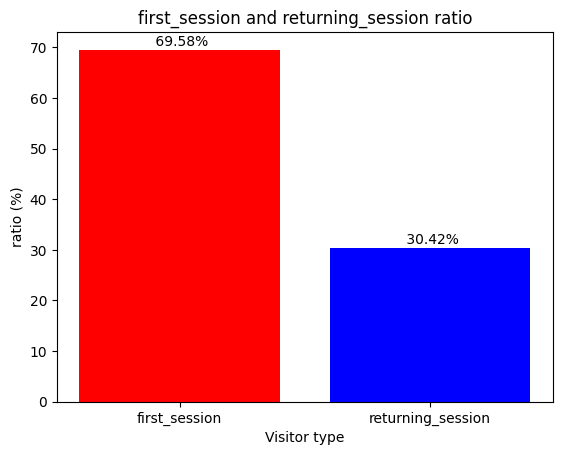

In [680]:
labels = ['first_session', 'returning_session']
ratios = [first_session_ratio, returning_session_ratio]

plt.bar(labels, ratios, color=['red', 'blue'])


plt.title('first_session and returning_session ratio')
plt.xlabel('Visitor type')
plt.ylabel('ratio (%)')
plt.text(0, ratios[0]+0.7, f'{ratios[0]: .2f}%', ha='center')
plt.text(1, ratios[1]+0.7, f'{ratios[1]: .2f}%', ha='center')

# 그래프 출력
plt.show()

In [681]:
df_set=df.loc[(df['trafficSource_campaign'] != '(not set)')]
df_not_set=df.loc[(df['trafficSource_campaign'] == '(not set)')]

## 채널별 효과 분석 (재혁)
    - 캠페인으로 들어온 사람은 다른 사람과 다른 특징을 가지고 있는지 분석
    - 매출이 우수한 채널이 있는지

### 시간대 별 추이

캠페인에 참여한 사람들은 10시에 접속수가 가장 적고, 4,15,18시가 가장 많은 접속이 이루어지는걸 볼 수 있음.

캠페인 참여 안한 사람들은 5시에 최저, 17,18시가 가장 많은 접속 했음을 알 수 있고,  캠페인에 참여하지 않은 사람들은 주로 오후에 활동하는것으로 판단된다.

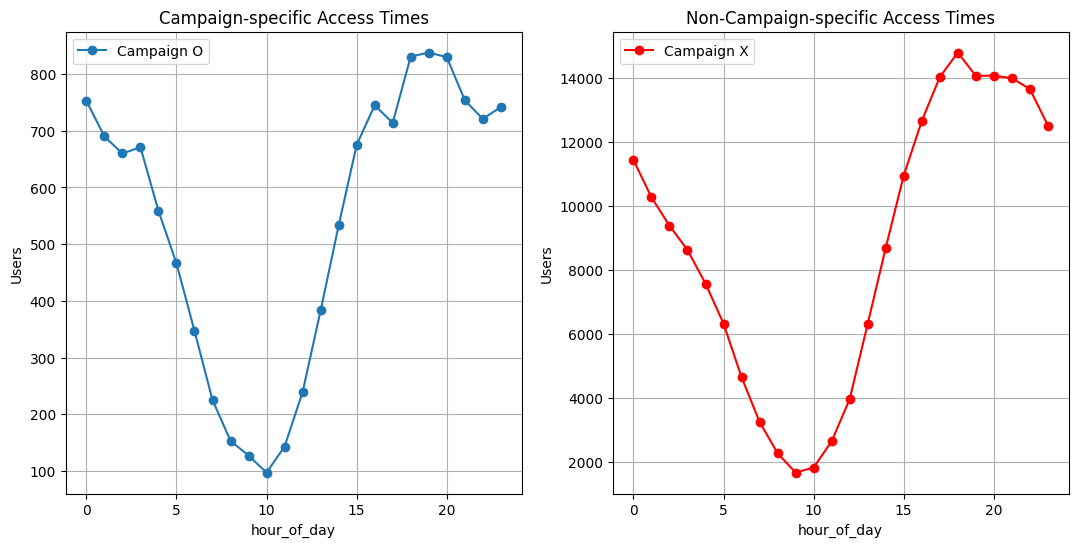

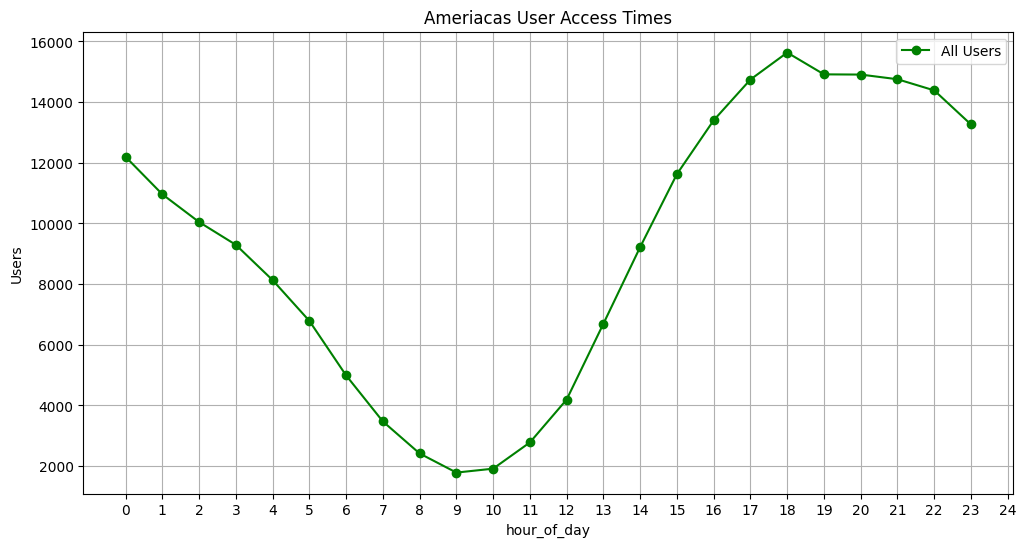

In [682]:
#캠페인에 따른 시간대 별 차이

plt.figure(figsize=(20,6))
plt.subplot(1,3,1)
df_set.groupby('hour_of_day')['hour_of_day'].value_counts().plot(kind='line',label='Campaign O',marker='o')
plt.title('Campaign-specific Access Times')
plt.ylabel('Users')
plt.grid()
plt.legend()

plt.subplot(1,3,2)
df_not_set.groupby('hour_of_day')['hour_of_day'].value_counts().plot(kind='line',color='red',label='Campaign X',marker='o')
plt.title('Non-Campaign-specific Access Times')
plt.ylabel('Users')
plt.grid()
plt.legend()
plt.show()

plt.figure(figsize=(12,6))
df.groupby('hour_of_day')['hour_of_day'].value_counts().plot(kind='line',color='green',label='All Users',marker='o')
plt.title('Ameriacas User Access Times')
plt.ylabel('Users')
plt.xticks(range(25))
plt.grid()
plt.legend()

### 월별 추이 

- 공통점 :  16년 11월에 접속을 많이했다. 

 - 차이점 :  16년 11월 이후 떨어지는 추세였다가 반등하여 17년 6월에 캠페인으로 들어온 사람들은 고점을 기록
   - 17년 6월에 어떤 일이 있었기에 그들이 많이 방문했는가?   
   - 접속자 수를 보면 16년 11월, 17년 6월에 많은 매출이 나올 것이다.

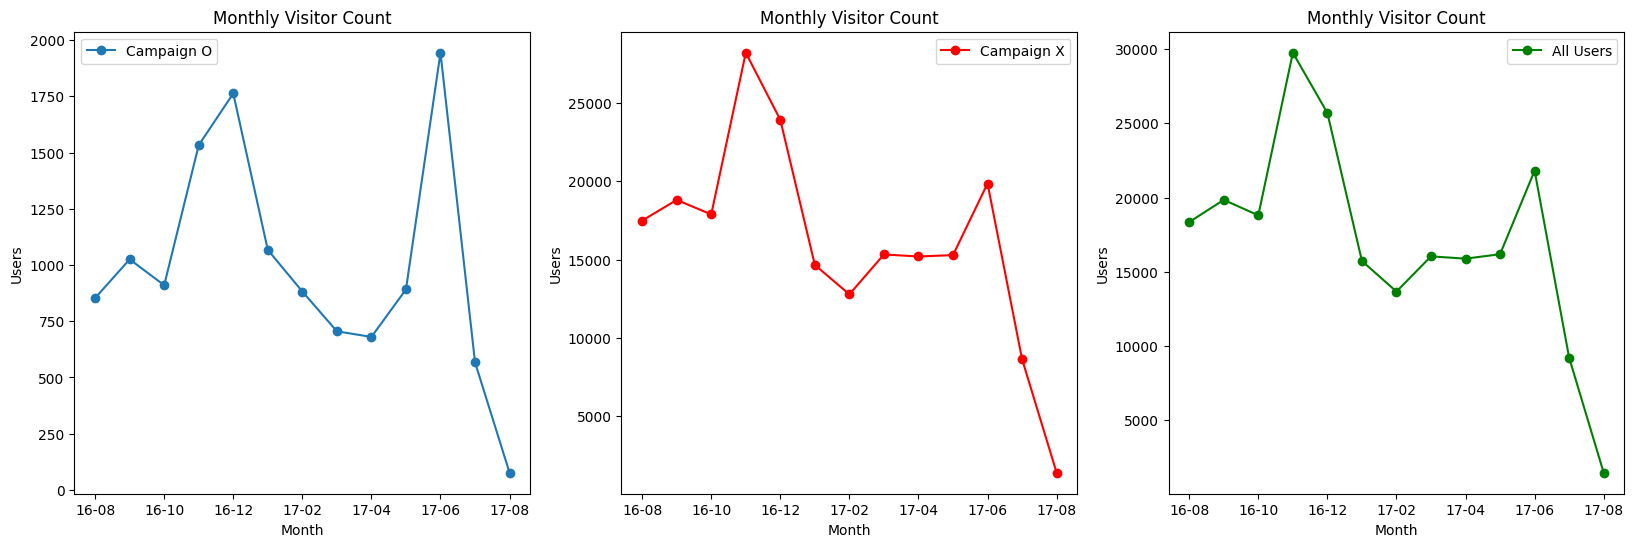

In [683]:
# 캠페인 별 접속한 월 추이
plt.figure(figsize=(20,6))
plt.subplot(1,3,1)
df_set['date_of_Month'].value_counts().sort_index().plot(kind='line',label='Campaign O', marker='o')
plt.title('Monthly Visitor Count')
plt.xlabel('Month')
plt.ylabel('Users')
plt.legend()

plt.subplot(1,3,2)
df_not_set['date_of_Month'].value_counts().sort_index().plot(kind='line',color='red',label='Campaign X', marker='o')
plt.title('Monthly Visitor Count')
plt.xlabel('Month')
plt.ylabel('Users')
plt.legend()

plt.subplot(1,3,3)
df['date_of_Month'].value_counts().sort_index().plot(kind='line',color='green',label='All Users', marker='o')
plt.title('Monthly Visitor Count')
plt.xlabel('Month')
plt.ylabel('Users')
plt.legend()


### 캠페인 별 매출 추이 
   - 캠페인으로 들어온 사람들은 17년 6월에 가장 많은 접속자를 기록했는데 매출은 두번째로 많이 접속했던 16년 11월이 1등을 기록
     - 왜? 17년 6월에는 접속자 수 대비 매출(거래 수익)이 줄었는가?

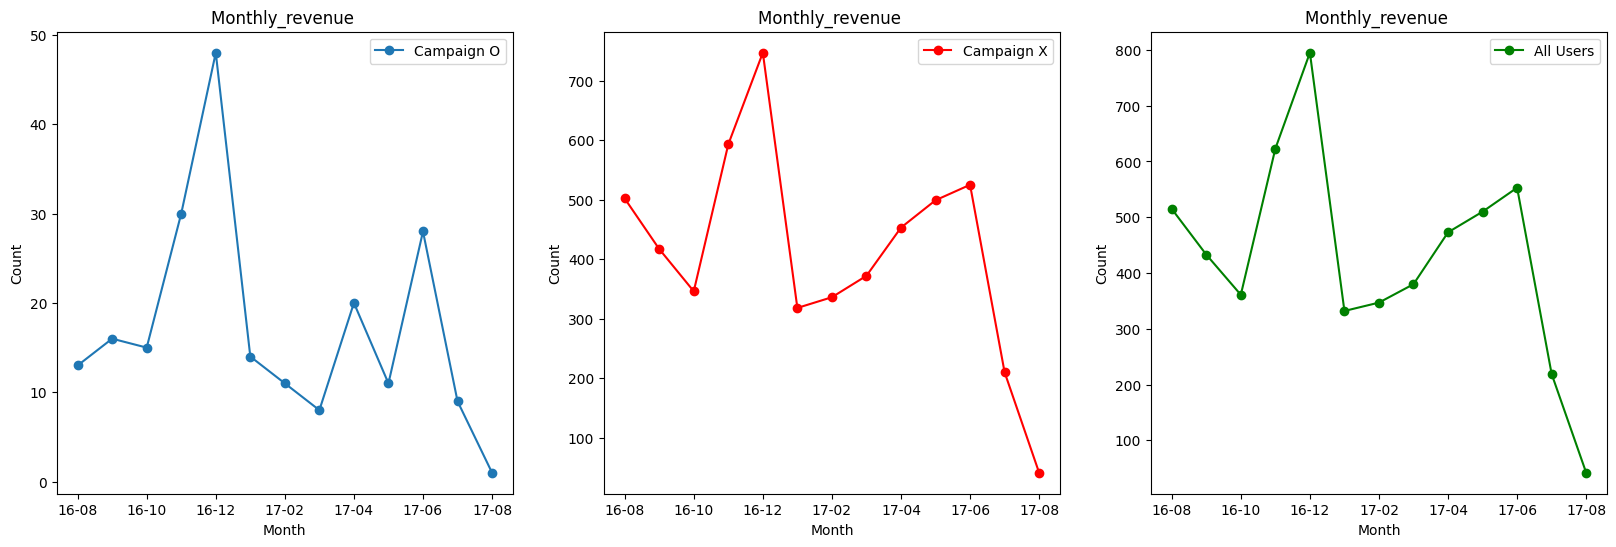

In [684]:
#캠페인 별 매출 추이
plt.figure(figsize=(20,6))

plt.subplot(1,3,1)
df_set.groupby('date_of_Month')['totals_transactionRevenue'].count().plot(kind='line',label='Campaign O' ,marker='o')
plt.title('Monthly_revenue ')
plt.xlabel('Month')
plt.ylabel('Count')
plt.legend()


plt.subplot(1,3,2)
df_not_set.groupby('date_of_Month')['totals_transactionRevenue'].count().plot(kind='line',label='Campaign X',color='red', marker='o')
plt.title('Monthly_revenue ')
plt.xlabel('Month')
plt.ylabel('Count')
plt.legend()

plt.subplot(1,3,3)
df.groupby('date_of_Month')['totals_transactionRevenue'].count().plot(kind='line',label='All Users',color='green', marker='o')
plt.title('Monthly_revenue ')
plt.xlabel('Month')
plt.ylabel('Count')
plt.legend()

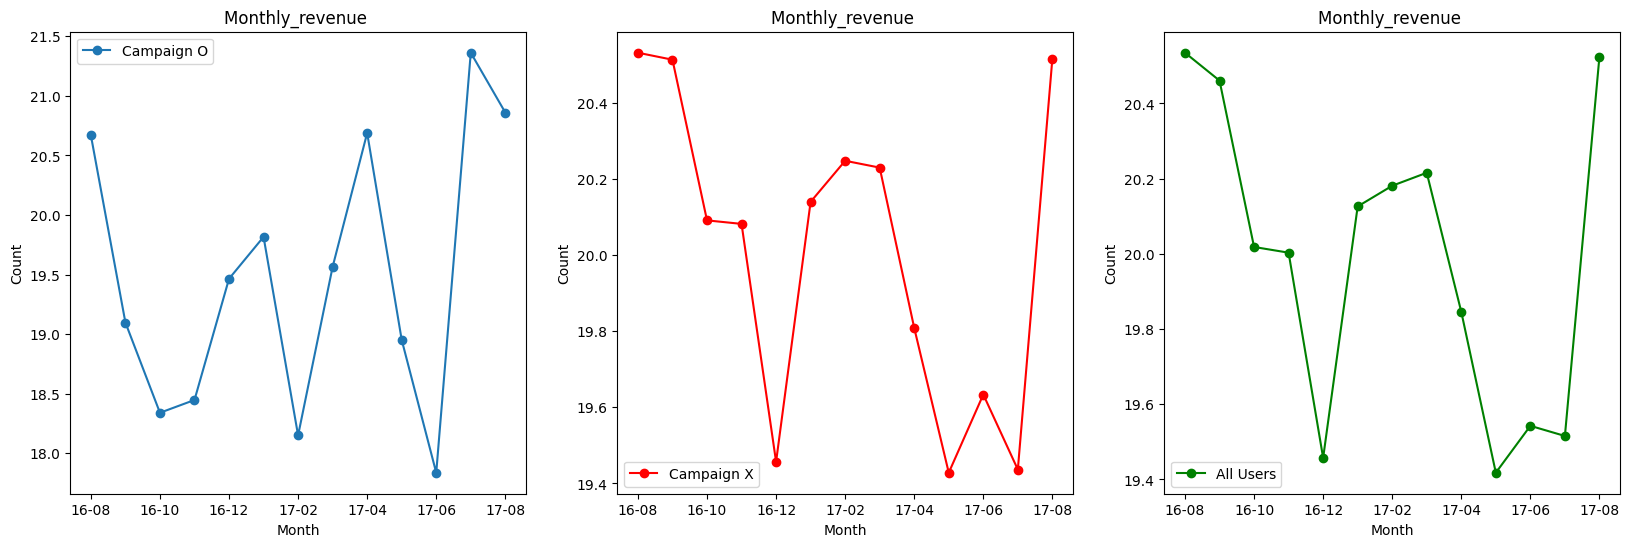

In [685]:
#캠페인 별 매출 추이
plt.figure(figsize=(20,6))

plt.subplot(1,3,1)
df_set.groupby('date_of_Month')['totals_transactionRevenue'].mean().plot(kind='line',label='Campaign O' ,marker='o')
plt.title('Monthly_revenue ')
plt.xlabel('Month')
plt.ylabel('Count')
plt.legend()


plt.subplot(1,3,2)
df_not_set.groupby('date_of_Month')['totals_transactionRevenue'].mean().plot(kind='line',label='Campaign X',color='red', marker='o')
plt.title('Monthly_revenue ')
plt.xlabel('Month')
plt.ylabel('Count')
plt.legend()

plt.subplot(1,3,3)
df.groupby('date_of_Month')['totals_transactionRevenue'].mean().plot(kind='line',label='All Users',color='green', marker='o')
plt.title('Monthly_revenue ')
plt.xlabel('Month')
plt.ylabel('Count')
plt.legend()

### 캠페인 여부에 따른 검색 유형

- 캠패인에 참여 안한 사람들은 40%는 Organic( 검색엔진에 키워드를 통해 웹사이트에 유입)

  - 27%의 사람들은 Social을 통한 유입, 14%는 Direct로 유입,  0.3%의 사람들이 Paid Search(유료 광고 )로 유입

-  캠페인에 참여한 사람들은 55% 사람들은Paid Search(유료 검색)으로 들어옴.
 
   - 44%의 사람들이 Affiliates(제휴 | 계열사) 로 들어옴.

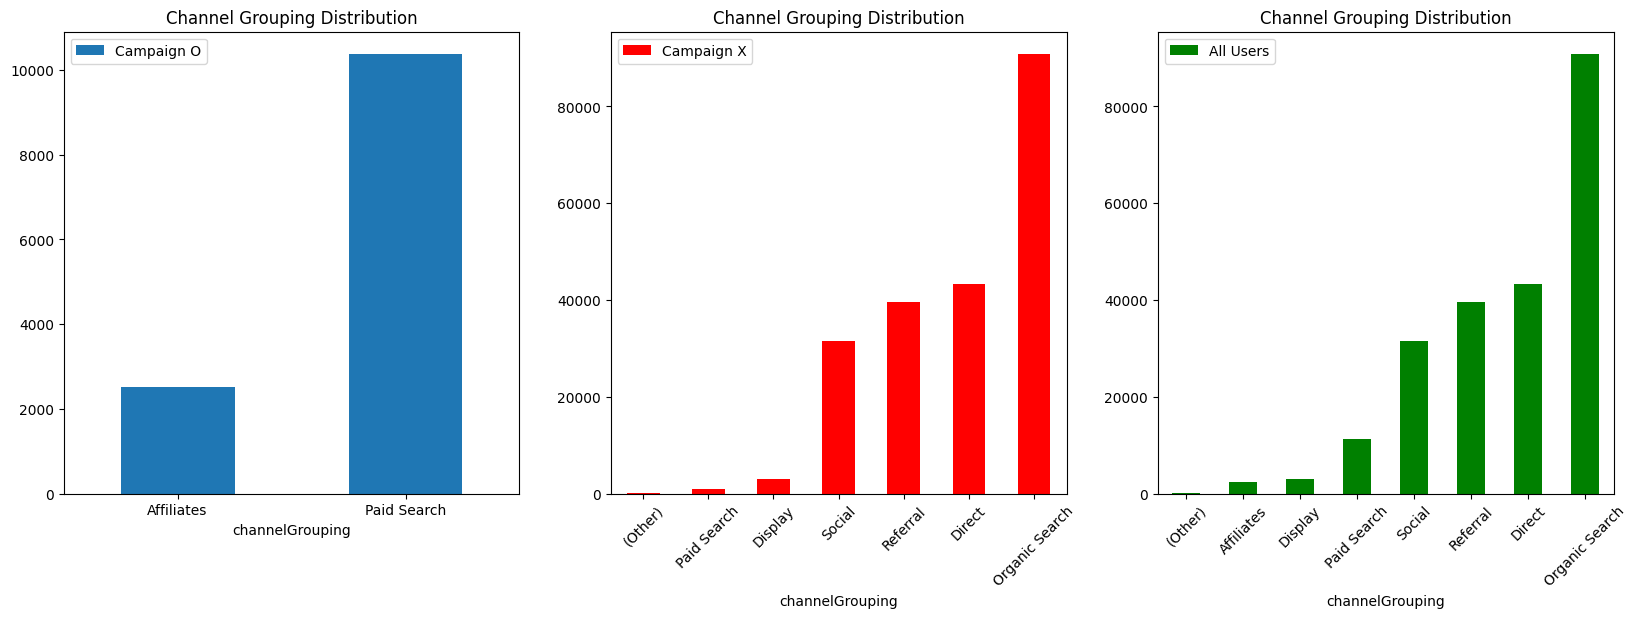

In [686]:
# 켐페인 별 검색 유형  
plt.figure(figsize=(20,6))
plt.subplot(1,3,1)
df_set['channelGrouping'].value_counts().sort_values().plot(kind='bar',label='Campaign O')
plt.title('Channel Grouping Distribution')
plt.xticks(rotation = 0)
plt.legend()


plt.subplot(1,3,2)
df_not_set['channelGrouping'].value_counts().sort_values().plot(kind='bar',color='red', label='Campaign X')
plt.title('Channel Grouping Distribution')
plt.xticks(rotation=45)
plt.legend()


plt.subplot(1,3,3)
df['channelGrouping'].value_counts().sort_values().plot(kind='bar',color='green', label='All Users')
plt.title('Channel Grouping Distribution')
plt.xticks(rotation=45)
plt.legend()

### 캠페인 별 유입 소스 차이
2개의 그래프 모두 다 Google이 1등을 차지 했지만
캠페인에 참여한 사람들은 Partners를 통해 많이 들어온다.  ->> 검색 유형에서도 알 수 있듯이 Affiliates와 연관이 있을 것이라고 생각

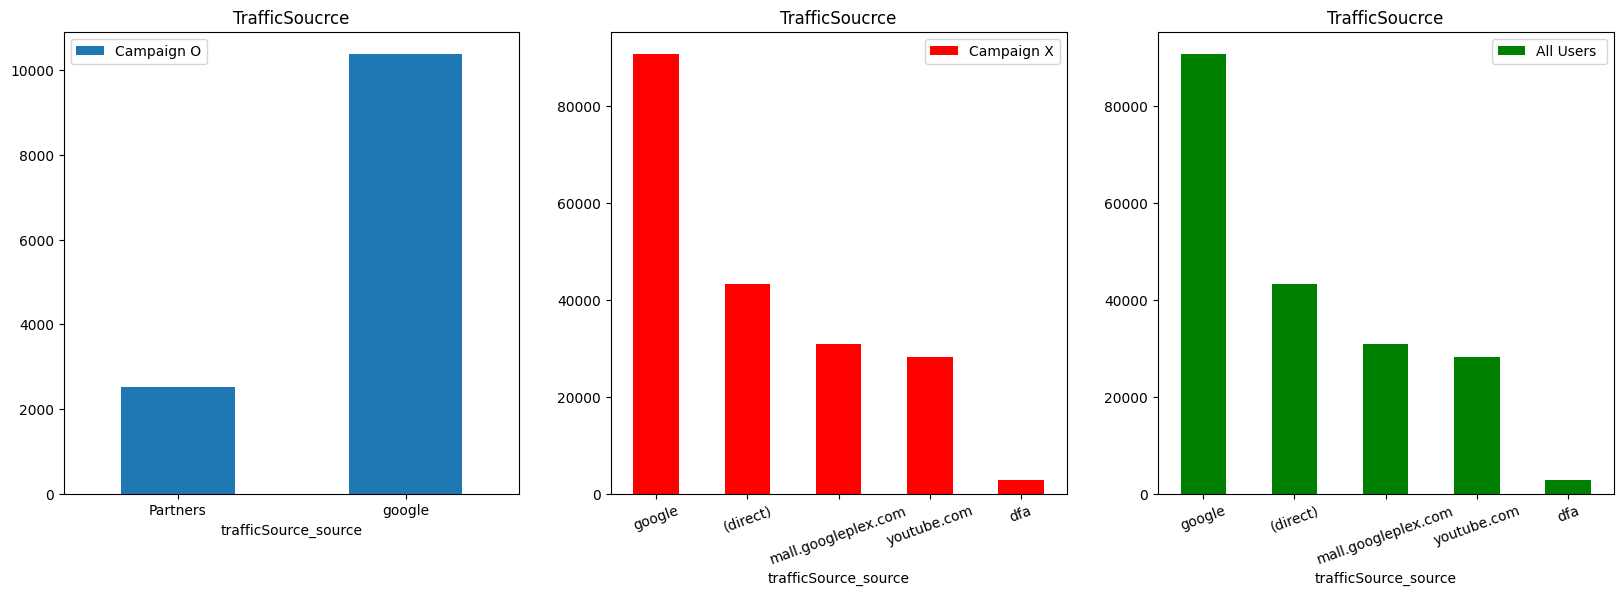

In [687]:
#캠페인 별 유입 소스 차이
top5_source=df_not_set['trafficSource_source'].value_counts().nlargest(n=5)
plt.figure(figsize=(20,6))

plt.subplot(1,3,1)
df_set['trafficSource_source'].value_counts().sort_index().plot(kind='bar',label='Campaign O')
plt.title('TrafficSoucrce')
plt.xticks(rotation=0)
plt.legend()

plt.subplot(1,3,2)
top5_source.plot(kind='bar',label='Campaign X',color='red')
plt.title('TrafficSoucrce')
plt.xticks(rotation = 20)
plt.legend()

plt.subplot(1,3,3)
top5_source.plot(kind='bar',label='All Users ',color='green')
plt.title('TrafficSoucrce')
plt.xticks(rotation = 20)
plt.legend()

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]),
 [Text(0, 0, '16-08'),
  Text(1, 0, '16-09'),
  Text(2, 0, '16-10'),
  Text(3, 0, '16-11'),
  Text(4, 0, '16-12'),
  Text(5, 0, '17-01'),
  Text(6, 0, '17-02'),
  Text(7, 0, '17-03'),
  Text(8, 0, '17-04'),
  Text(9, 0, '17-05'),
  Text(10, 0, '17-06'),
  Text(11, 0, '17-07'),
  Text(12, 0, '17-08')])

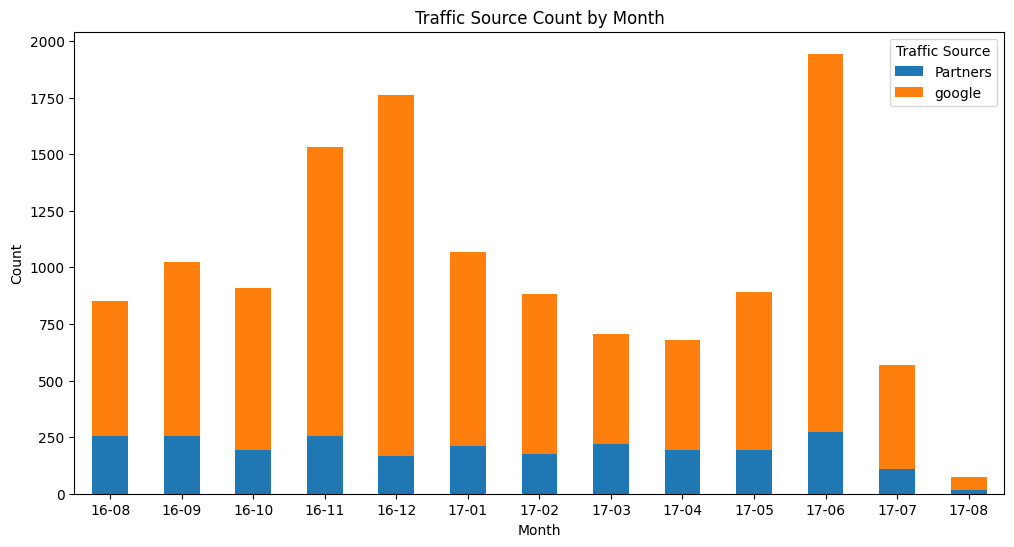

In [688]:

df_set_Month_traffic=df_set.groupby('date_of_Month')['trafficSource_source'].value_counts().unstack(fill_value=0)
df_set_Month_traffic.plot(kind='bar',stacked=True,figsize=(12,6))
plt.title('Traffic Source Count by Month')
plt.xlabel('Month')
plt.ylabel('Count')
plt.legend(title='Traffic Source')
plt.xticks(rotation=0) 


### 시간대 별 트래픽 소스
- 캠페인으로 들어온 사람들은 보통 Paid Search를 통해 들어온다.  이를 많이 늘리기 위해서는  google과 youtube의 홍보를 많이 하여 Paid Search의 비율을 늘린다.\
그러면 왜 늘리는거지?  늘리면 뭐가 좋지? 많이 돈을 쓰는것도 아니고


###  chnnel별 페이지 수 

In [689]:
# set_counts=df_set.groupby('channelGrouping')['totals_pageviews'].count()
# total_set_counts=df_set['totals_pageviews'].count()
# pageviews_ratio_set = set_counts / total_set_counts

# totals_page_revenue=df_set.groupby('channelGrouping')['totals_pageviews'].sum()
# revenue_per_pagecount=totals_page_revenue/total_set_counts


# plt.figure(figsize=(20,10))
# plt.subplot(2,3,1)
# set_counts.plot(kind='bar',label='Campaign O')
# plt.xticks(rotation=0)
# plt.text(0.85,set_counts[0]+100,set_counts[0])
# plt.text(1.85,set_counts[1]+100,set_counts[1])
# plt.title('pageview by chnnel')
# plt.ylabel('total_pageview')
# plt.legend()

# plt.subplot(2,3,2)
# pageviews_ratio_set.plot(kind='bar',label='Campaign O')
# plt.xticks(rotation=0)
# plt.text(0.85,pageviews_ratio_set[1]+0.01, f'{pageviews_ratio_set[1] : .2f}%')
# plt.text(1.85,pageviews_ratio_set[2]+0.01,f'{pageviews_ratio_set[2] : .2f}%')
# plt.title('totals_pageview_ratio by chnnel')
# plt.ylabel('ratio')
# plt.legend()

# plt.subplot(2,3,3)
# revenue_per_pagecount.plot(kind='bar',label='Campaign O')
# plt.xticks(rotation=0)
# plt.text(0.85,revenue_per_pagecount[1], f'{revenue_per_pagecount[1] : .2f}')
# plt.text(1.85,revenue_per_pagecount[2],f'{revenue_per_pagecount[2] : .2f}')
# plt.title('pageview by chnnel')
# plt.ylabel('pageview')
# plt.legend()

# not_set_counts=df_not_set.groupby('channelGrouping')['totals_pageviews'].count()
# total_not_set_counts=df_not_set['totals_pageviews'].count()
# pageviews_ratio_not_set = not_set_counts / total_not_set_counts

# totals_page_revenue_notset=df_not_set.groupby('channelGrouping')['totals_pageviews'].sum()
# chnnel_per_pagecount_notset=totals_page_revenue_notset/total_not_set_counts



# plt.subplot(2,3,4)
# not_set_counts.plot(kind='bar',color='red',label='Campaign X')
# plt.xticks(rotation=45)
# plt.text(2.65,not_set_counts[3]+500,not_set_counts[3])
# plt.text(3.8,not_set_counts[4]+500,not_set_counts[4])
# plt.title('pageview by chnnel')
# plt.ylabel('total_pageview')
# plt.legend()

# plt.subplot(2,3,5)
# pageviews_ratio_not_set.plot(kind='bar',color='red',label='Campaign X')
# plt.xticks(rotation=45)
# plt.text(2.5,pageviews_ratio_not_set[3], f'{pageviews_ratio_not_set[3] : .4f}%')
# plt.text(3.5,pageviews_ratio_not_set[4],f'{pageviews_ratio_not_set[4] : .4f}%')
# plt.title('totals_pageview_ratio by chnnel')
# plt.ylabel('ratio')
# plt.legend()

# plt.subplot(2,3,6)
# chnnel_per_pagecount_notset.plot(kind='bar',color='red',label='Campaign X')
# plt.xticks(rotation=45)
# plt.text(2.65,chnnel_per_pagecount_notset[3], f'{chnnel_per_pagecount_notset[3] : .2f}')
# plt.text(3.65,chnnel_per_pagecount_notset[4],f'{chnnel_per_pagecount_notset[4] : .2f}')
# plt.title('pageview by chnnel')
# plt.ylabel('pageview')
# plt.tight_layout()
# plt.legend()


캠페인을 통해 들어온 사람들은 paid와 affiliates을 통해 들어오며, 이 그룹은 보통 페이지뷰를 평균적으로 1~3까지 보는것으로 나타났다.  \
이에 반해 Not캠페인그룹은 paid를 통해 들어오는 사람이 적으면서 페이지뷰도 0.01이라는 수치를 보여주고있다. 이 그룹은 Organic Search를 통해서 오는 경우에 1.75페이지를 기록하였다.\
\
따라서  캠페인그룹이 페이지수를 더 많이 보는 것으로 보임.  \
페이지 수를 1 이상으로 설정해서  사실상 0이 1을 나타냄
즉 페이지 수가 1인 상황에서 오히려 많은 거래 수익이 있다.

### 페이지 뷰에 따른 매출 비교

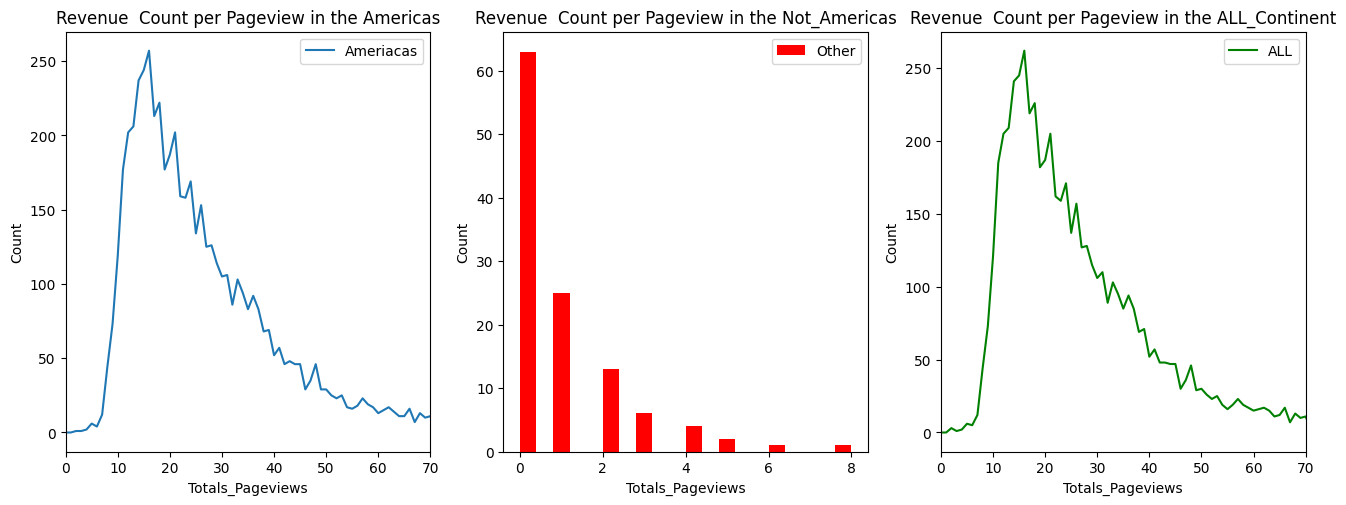

In [716]:
# 페이지뷰에 따른 거래 수익 비교, Not캠페인 그룹은 0이 너무 많아서 log변환을 해서 그래프를 한번 그려봄

page_revenue= df.groupby('totals_pageviews')['totals_transactionRevenue'].count()
page_revenue_notset=df.groupby('totals_pageviews')['totals_transactionRevenue'].count()
revenue_notset_page_counts = df.groupby('totals_pageviews')['totals_transactionRevenue'].count()



plt.figure(figsize=(16, 12))
plt.subplot(2,3,1)
page_revenue.plot(kind='line',label='Ameriacas')
plt.xlim([0,70])
# plt.hist(page_revenue, bins=50,label='Americas')  
plt.legend()
plt.ylabel('Count')  
plt.xlabel('Totals_Pageviews') 
plt.title('Revenue  Count per Pageview in the Americas') 





page_revenue= df_other.groupby('totals_pageviews')['totals_transactionRevenue'].count()
page_revenue_notset=df_other.groupby('totals_pageviews')['totals_transactionRevenue'].count()
revenue_notset_page_counts = df_other.groupby('totals_pageviews')['totals_transactionRevenue'].count().sort_index()
plt.subplot(2,3,2)
# np.log1p(page_revenue_notset).plot(kind='hist')
revenue_notset_page_counts.plot(kind='hist',color='red',label='Other',bins=20)
plt.ylabel('Count')  
plt.xlabel('Totals_Pageviews') 
plt.title('Revenue  Count per Pageview in the Not_Americas') 
plt.legend()


page_revenue= df_all.groupby('totals_pageviews')['totals_transactionRevenue'].count()
page_revenue_notset=df_all.groupby('totals_pageviews')['totals_transactionRevenue'].count()
revenue_notset_page_counts = df_all.groupby('totals_pageviews')['totals_transactionRevenue'].count()
plt.subplot(2,3,3)
# np.log1p(page_revenue_notset).plot(kind='hist')
revenue_notset_page_counts.plot(kind='line',color='green',label='ALL')
plt.xlim([0,70])
plt.ylabel('Count')  
plt.xlabel('Totals_Pageviews') 
plt.title('Revenue  Count per Pageview in the ALL_Continent') 
plt.legend()

# plt.subplot(2,2,3)
# np.log1p(page_revenue).plot(kind='hist',bins=20,label= 'campaign O')

# plt.ylabel('Count')   
# plt.xlabel('Totals_Pageviews') 
# plt.title('Total Transaction Revenue by Pageviews') 
# plt.legend()



# plt.subplot(2,2,4)
# np.log1p(revenue_notset_page_counts).plot(kind='hist',color='red',bins=20,label='Campaign X')
# # plt.hist(revenue_notset_page_counts, bins=20,color='red')  
# plt.ylabel('Count')  
# plt.xlabel('Totals_Pageviews') 
# plt.title('Total Transaction Revenue by Pageviews') 
# plt.show()



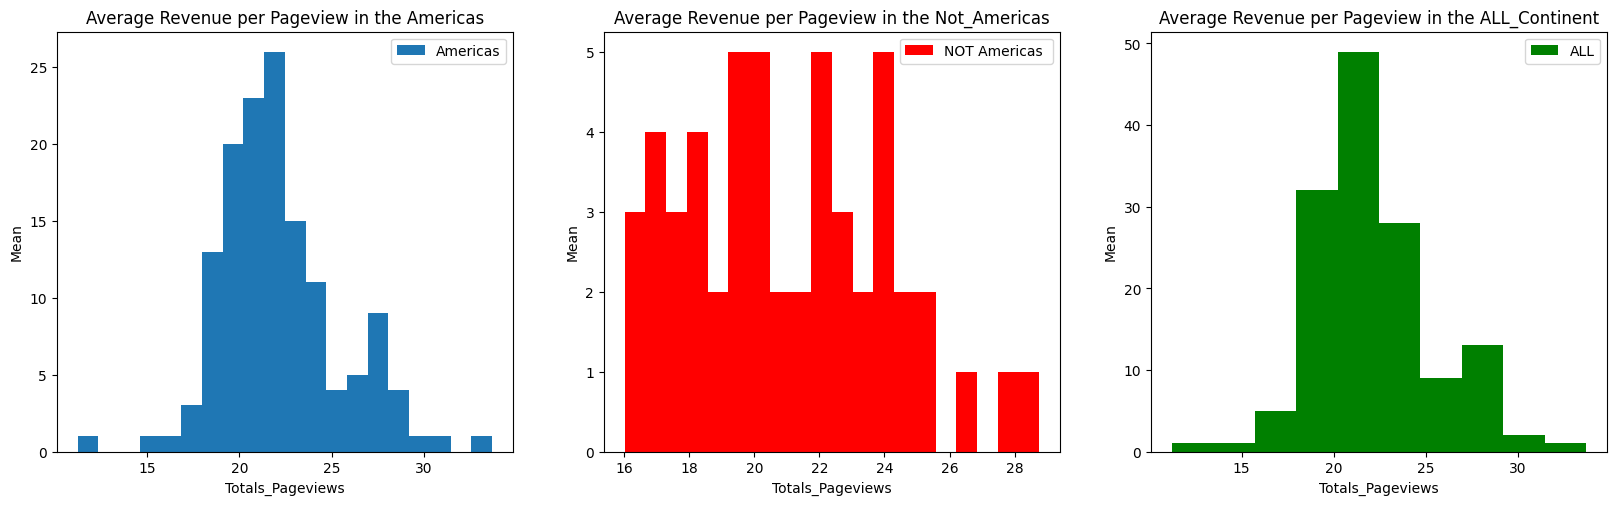

In [691]:

page_revenue= df.groupby('totals_pageviews')['totals_transactionRevenue'].mean()
page_revenue_set=df.groupby('totals_pageviews')['totals_transactionRevenue'].mean()
revenue_set_page_counts = df.groupby('totals_pageviews')['totals_transactionRevenue'].mean()

plt.figure(figsize=(20, 12))
plt.subplot(2,3,1)
plt.hist(page_revenue, bins=20,label='Americas')  
plt.legend()
plt.ylabel('Mean')  
plt.xlabel('Totals_Pageviews') 
plt.title('Average Revenue per Pageview in the Americas') 





page_revenue= df_other.groupby('totals_pageviews')['totals_transactionRevenue'].mean()
page_revenue_notset=df_other.groupby('totals_pageviews')['totals_transactionRevenue'].mean()
revenue_notset_page_counts = df_other.groupby('totals_pageviews')['totals_transactionRevenue'].mean()
plt.subplot(2,3,2)
# np.log1p(page_revenue_notset).plot(kind='hist')
plt.hist(revenue_notset_page_counts, bins=20,color='red',label='NOT Americas ')  
plt.ylabel('Mean')  
plt.xlabel('Totals_Pageviews') 
plt.title('Average Revenue per Pageview in the Not_Americas') 
plt.legend()



page_revenue_all= df_all.groupby('totals_pageviews')['totals_transactionRevenue'].mean()
page_revenue_all=df_all.groupby('totals_pageviews')['totals_transactionRevenue'].mean()
revenue_all_page_counts = df_all.groupby('totals_pageviews')['totals_transactionRevenue'].mean()
plt.subplot(2,3,3)
# np.log1p(page_revenue_notset).plot(kind='hist')
revenue_all_page_counts.plot(kind='hist',color='green',label='ALL')
plt.ylabel('Mean')  
plt.xlabel('Totals_Pageviews') 
plt.title('Average Revenue per Pageview in the ALL_Continent') 
plt.legend()

In [692]:
# # revenue_set_page_counts=df_set.groupby('totals_pageviews')['totals_transactionRevenue'].count()


# plt.figure(figsize=(12,6))


# plt.subplot(1,2,1)
# revenue_set_page_counts = df_set.groupby('totals_pageviews')['totals_transactionRevenue'].count()
# revenue_set_page_counts.plot(kind='hist')
# plt.title('Revenue by pageview')
# plt.xlabel('pageview')
# plt.ylabel('Revenue')
# plt.legend()


# plt.subplot(1,2,2)
# revenue_notset_page_counts =df_not_set.groupby('totals_pageviews')['totals_transactionRevenue'].count()
# revenue_notset_page_counts.plot(kind='hist')
# plt.title('Revenue by pageview')
# plt.xlabel('pageview')
# plt.ylabel('Revenue')
# plt.legend()
# plt.show()


## 구매 전환률

### 캠페인별 구매 전환율

In [693]:
# df_nost_set : 캠페인 X 그룹
#  df_not_set['totals_transactionRevenue'].count() : 캠페인 X인 그룹들 중 구매수 
# df_not_set['fullVisitorId'].count() : 캠페인 X인 그룹의 유저 수 

df_not_set['totals_transactionRevenue'].count() / df['totals_transactionRevenue'].count()

display(f" 캠페인 X인 그룹들 중 구매수 : {df_not_set['totals_transactionRevenue'].count()} ")
display(f" 캠페인 X인 그룹의 유저 수: {df_not_set['fullVisitorId'].count()}")
display(f"NOT캠페인 그룹의 구매 전환율 : {df_not_set['totals_transactionRevenue'].count() / df_not_set['fullVisitorId'].count():.4f}%")

display('===================================================')

display(f" 캠페인 X인 그룹들 중 구매수 : {df_set['totals_transactionRevenue'].count()} ")
display(f" 캠페인 X인 그룹의 유저 수: {df_set['fullVisitorId'].count()}")
display(f"캠페인 그룹의 구매 전환율 : {df_set['totals_transactionRevenue'].count() / df_set['fullVisitorId'].count():.4f}%")

print('===================================================')
print(f" 전체 그룹들 중 구매수 : {df['totals_transactionRevenue'].count()} ")
print(f" 전체 그룹의 유저 수: {df['fullVisitorId'].count()}")
print(f" 전체 그룹의 구매 전환율 : {df['totals_transactionRevenue'].count() / df['fullVisitorId'].count():.4f}%")

' 캠페인 X인 그룹들 중 구매수 : 5359 '

' 캠페인 X인 그룹의 유저 수: 209519'

'NOT캠페인 그룹의 구매 전환율 : 0.0256%'

'==================================================='

' 캠페인 X인 그룹들 중 구매수 : 224 '

' 캠페인 X인 그룹의 유저 수: 12896'

'캠페인 그룹의 구매 전환율 : 0.0174%'

 전체 그룹들 중 구매수 : 5583 
 전체 그룹의 유저 수: 222415
 전체 그룹의 구매 전환율 : 0.0251%


### 아메리카 시간대 별  구매 전환률 

Text(0.5, 1.0, 'Purchase Conversion Rate by Hour for All Users')

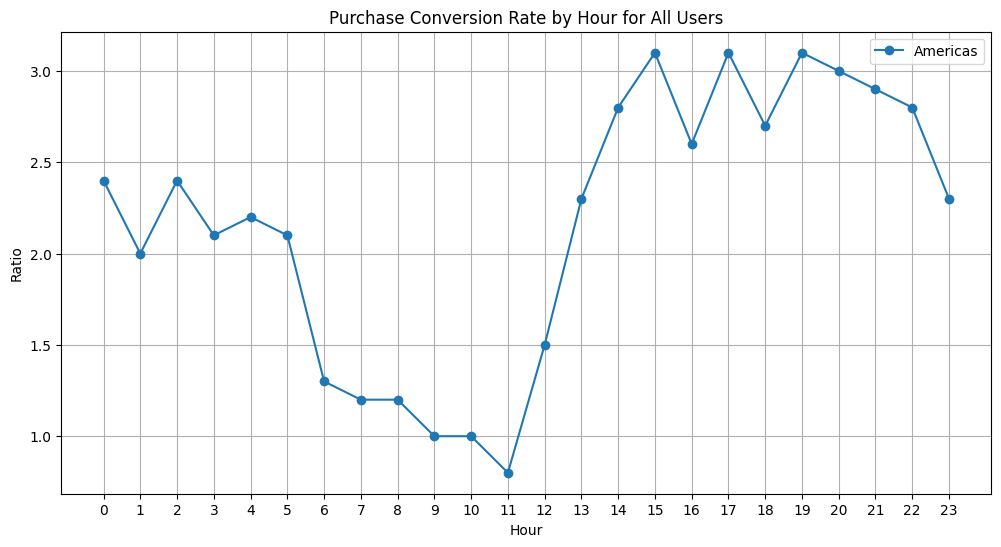

In [694]:
cnt_by_hour=(df.groupby('hour_of_day')['totals_transactionRevenue'].count() / df.groupby('hour_of_day')['fullVisitorId'].count()).round(3)
plt.figure(figsize=(12,6))
plt.plot(cnt_by_hour.index,cnt_by_hour.values.round(3)*100,marker='o',label='Americas')
plt.xticks(cnt_by_hour.index)
plt.xlabel('Hour')
plt.ylabel('Ratio')
plt.legend()
plt.grid()
plt.title('Purchase Conversion Rate by Hour for All Users')

In [695]:
df.loc[(df['hour_of_day'] == 15 ) | (df['hour_of_day'] == 17) | (df['hour_of_day'] == 19)]['device_deviceCategory'].value_counts()


result=df.loc[(df['hour_of_day'] == 15 ) | (df['hour_of_day'] == 17) | (df['hour_of_day'] == 19)]['visitNumber'].value_counts(normalize=True).round(2)
result[result > 0.00]

df.loc[(df['hour_of_day'] == 15 ) | (df['hour_of_day'] == 17) | (df['hour_of_day'] == 19)]['trafficSource_source'].value_counts()




trafficSource_source
google                 17611
(direct)                8416
mall.googleplex.com     6926
youtube.com             4719
dfa                      580
                       ...  
wheretoget.it              1
plus.url.google.com        1
en.wikipedia.org           1
google.cl                  1
chat.google.com            1
Name: count, Length: 108, dtype: int64

(array([0, 1, 2, 3, 4, 5, 6, 7]),
 [Text(0, 0, 'google'),
  Text(1, 0, 'youtube.com'),
  Text(2, 0, '(direct)'),
  Text(3, 0, 'analytics.google.com'),
  Text(4, 0, 'Partners'),
  Text(5, 0, 'mall.googleplex.com'),
  Text(6, 0, 'baidu'),
  Text(7, 0, 'google.com')])

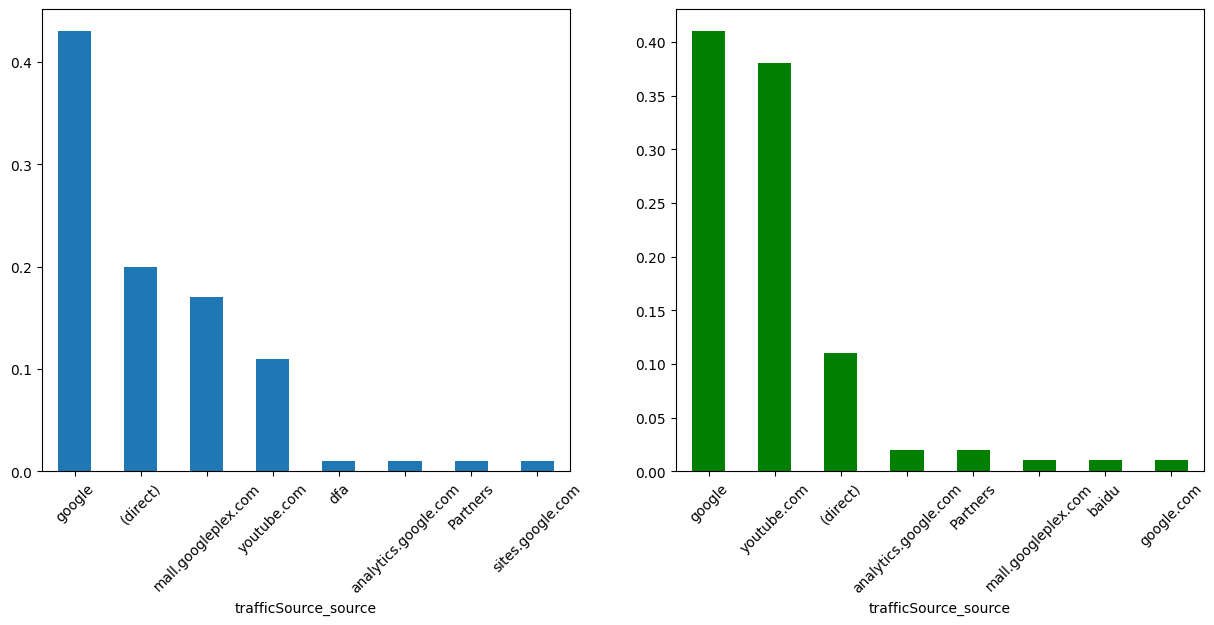

In [696]:
plt.figure(figsize=(15, 6))
plt.subplot(1,2,1)
result22=df.loc[(df['hour_of_day'] == 15 ) | (df['hour_of_day'] == 17) | (df['hour_of_day'] == 19)]['trafficSource_source'].value_counts(normalize=True).round(2)
result22[result22>0.00].plot(kind='bar')
plt.xticks(rotation=45)

plt.subplot(1,2,2)
result1=df_other.trafficSource_source.value_counts(normalize=True).round(2)
result1[result1>0].plot(kind='bar',color='green')
plt.xticks(rotation=45)

In [697]:
df_other.loc[(df_other['hour_of_day'] == 15 ) | (df_other['hour_of_day'] == 17) | (df_other['hour_of_day'] == 19)]['trafficSource_source'].value_counts(normalize=True).round(2)

trafficSource_source
google                      0.44
youtube.com                 0.37
(direct)                    0.11
analytics.google.com        0.02
Partners                    0.02
                            ... 
businessinsider.com         0.00
nl.yhs4.search.yahoo.com    0.00
hangouts.google.com         0.00
moma.corp.google.com        0.00
nl.search.yahoo.com         0.00
Name: proportion, Length: 101, dtype: float64

In [698]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 222415 entries, 14 to 449999
Data columns (total 27 columns):
 #   Column                                        Non-Null Count   Dtype         
---  ------                                        --------------   -----         
 0   channelGrouping                               222415 non-null  object        
 1   date                                          222415 non-null  datetime64[ns]
 2   fullVisitorId                                 222415 non-null  object        
 3   sessionId                                     222415 non-null  object        
 4   visitId                                       222415 non-null  int64         
 5   visitNumber                                   222415 non-null  int64         
 6   visitStartTime                                222415 non-null  datetime64[ns]
 7   device_isMobile                               222415 non-null  bool          
 8   device_deviceCategory                         222415 non-n

geoNetwork_continent
Americas    19.916255
Name: totals_transactionRevenue, dtype: float64


geoNetwork_continent
(not set)    20.15
Africa       35.17
Asia         21.03
Europe       18.73
Oceania      21.38
Name: totals_transactionRevenue, dtype: float64

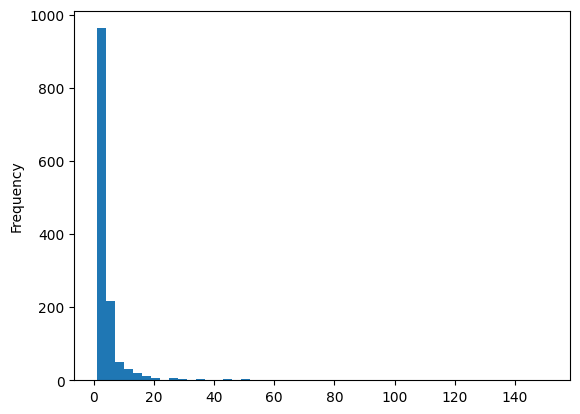

In [699]:
df['totals_transactionRevenue'].value_counts().plot(kind='hist',bins=50)
print(df.groupby('geoNetwork_continent')['totals_transactionRevenue'].mean())
df_other.groupby('geoNetwork_continent')['totals_transactionRevenue'].mean().round(2)

In [700]:
df_other.groupby('geoNetwork_continent')['totals_transactionRevenue'].mean().sort_values().round(2)

geoNetwork_continent
Europe       18.73
(not set)    20.15
Asia         21.03
Oceania      21.38
Africa       35.17
Name: totals_transactionRevenue, dtype: float64

In [701]:
df.groupby('geoNetwork_continent')['totals_transactionRevenue'].mean().round(2)

geoNetwork_continent
Americas    19.92
Name: totals_transactionRevenue, dtype: float64